### tsdGAN: A generative adversarial network approach for removing electrocardiographic interference from electromyographic signals 
Lucas Haberkamp<sup>1,2</sup> Charles A. Weisenbach<sup>1</sup> Peter Le<sup>3</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Leidos, Reston, VA, USA   
<sup>3</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA

#### This notebook generates a synthetic EMG dataset that is corrupted with ECG 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from sklearn.utils import shuffle
import pickle
import plotly.graph_objects as go

Define helper function to load in EMG dataset

In [2]:
def extractdf(data_path, header):
    file_list, df_list = [], [] # initialize lists
    for filename in sorted(os.listdir(data_path)):
        f = os.path.join(data_path, filename) 
        if os.path.splitext(filename)[1] == '.csv':
            current_file = os.path.splitext(filename)[0] # get the identifier of the participant from the file
            file_list.append(current_file)  
            tmp_df = pd.read_csv(f, header=header)
            df_list.append(tmp_df)
    return df_list, file_list

In [3]:
# Specify paths
syn_path = '../../Data/Raw Synthetic Data'

# Extract the data as dataframes stored into lists
syn_data_list, syn_file_list = extractdf(syn_path, header=4)

print("Files in the synthetic dataset:", syn_file_list)

Files in the synthetic dataset: ['Run_number_58_Plot_and_Store_Rep_1.1', 'Run_number_58_Plot_and_Store_Rep_10.10', 'Run_number_58_Plot_and_Store_Rep_2.2', 'Run_number_58_Plot_and_Store_Rep_3.3', 'Run_number_58_Plot_and_Store_Rep_4.4', 'Run_number_58_Plot_and_Store_Rep_5.5', 'Run_number_58_Plot_and_Store_Rep_6.6', 'Run_number_58_Plot_and_Store_Rep_7.7', 'Run_number_58_Plot_and_Store_Rep_8.8', 'Run_number_58_Plot_and_Store_Rep_9.9']


In [4]:
df = syn_data_list[0]
df.head()

,X[s],Snap-Lead sensor 1: EMG 1,X[s].1,Snap-Lead sensor 2: EMG 2
0,0.000000,0.0,0.000000,0.0
1,0.000466,0.0,0.000466,0.0
2,0.000931,0.0,0.000931,0.0
3,0.001397,0.0,0.001397,0.0
4,0.001862,0.0,0.001862,0.0


In [5]:
# Set hyperparameters
Fs = 2148

# 5 second window
window_size = int(5*Fs)

# Set random seed
np.random.seed(42)

Use the Pans-Tompkins algorithm to detect QRS locations. "J. Pan and W. J. Tompkins, "A Real-Time QRS Detection Algorithm," in IEEE Transactions on Biomedical Engineering, vol. BME-32, no. 3, pp. 230-236, March 1985, doi: 10.1109/TBME.1985.325532."

In [6]:
def butterfilter(x, Fc, Fs, type, order=2):
    Wn = np.asarray(Fc)/np.asarray(Fs/2)
    b, a = signal.butter(order, Wn, type)
    return signal.filtfilt(b,a,x)

def getlabels(raw_inputs, plotting=False, saveplot=False):
  
  inputs = np.hstack([np.zeros(shape=(10,)), raw_inputs.squeeze(), np.zeros(shape=(10,))])

  filtered = butterfilter(inputs, Fc=[5, 12], Fs=Fs, type='bandpass')
  differentiate = pd.Series(np.gradient(filtered)*Fs)
  squared = differentiate**2
  integrated = squared.rolling(window=int(0.15*Fs), center=True, min_periods=1).mean()
  threshold = squared.rolling(window=int(1.5*Fs), center=True, min_periods=1).mean()

  if plotting:
    fontsize = 12
    lw = 2

    loc = 'upper right'

    t = np.arange(len(inputs)) / Fs
    fig, axs = plt.subplots(5, 1, sharex=True, figsize=(14, 12), facecolor='white')

    axs[0].plot(t, inputs, label='Contaminated EMG', color='k', linewidth=lw-0.5)
    axs[0].set_ylabel('Amplitude (\u00b5V)', fontsize=fontsize)
    axs[0].legend(fontsize=fontsize, loc=loc)

    axs[1].plot(t, filtered, label='5-12 Hz Bandpass Filtered', linewidth=lw)
    axs[1].set_ylabel('Amplitude (\u00b5V)', fontsize=fontsize)
    axs[1].legend(fontsize=fontsize, loc=loc)

    axs[2].plot(t, differentiate, label='Differentiated', color='crimson', linewidth=lw)
    axs[2].set_ylabel('\u0394Amplitude (\u00b5V/s)', fontsize=fontsize)
    axs[2].legend(fontsize=fontsize, loc=loc)

    axs[3].plot(t, squared, label='Squared', color='teal', linewidth=lw)
    axs[3].set_ylabel('\u0394Amplitude (\u00b5V\u00B2/s)', fontsize=fontsize)
    axs[3].legend(fontsize=fontsize, loc=loc)

    axs[4].plot(t, integrated, label='0.15s Moving Average', color='mediumpurple', linewidth=lw)
    axs[4].plot(t, threshold, label='1.50s Moving Average', color='red', linewidth=lw)
    axs[4].set_ylabel('\u0394Amplitude (\u00b5V\u00B2/s)', fontsize=fontsize)
    axs[4].legend(fontsize=fontsize, loc=loc)
    
    axs[4].set_xlabel('Time (s)', fontsize=fontsize)

    for i in range(5):
      axs[i].set_xlim(t[0], t[-1])
    
    if saveplot:
      plt.savefig("../../Plots/EMG Segmentation/EMG_segmentation.png", dpi=500)

    plt.show()

  curr_label = np.ones(shape=(inputs.shape[0], 1))
  curr_label[integrated > threshold] = 0
  return curr_label[10:-10]

Create EMG and ECG datasets, along with corresponding labels of QRS locations.

In [7]:
# Concatenate Bicep EMG data across trials
EMG_data = pd.concat([syn_data_list[0].iloc[:,1], syn_data_list[1].iloc[:,1], 
    syn_data_list[4].iloc[:,1], syn_data_list[5].iloc[:,1],
    syn_data_list[6].iloc[:,1], syn_data_list[7].iloc[:,1],
    syn_data_list[8].iloc[:,1], syn_data_list[9].iloc[:,1]
], axis=0)[1000:]

print(f"EMG data = {len(EMG_data)/Fs}s")

# Butterworth low-pass filter at 500-Hz cutoff
EMG_data = butterfilter(EMG_data, Fc=500, Fs=Fs, type='low')

EMG_gradient = np.abs(np.gradient(EMG_data))

# Concatenate ECG data across lying supine trials
ECG_data = pd.concat([syn_data_list[2].iloc[:,3], syn_data_list[3].iloc[:,3]], axis=0)[1000:]

print(f"ECG data = {len(ECG_data)/Fs}s")

# Butterworth low-pass filter at 100-Hz cutoff
ECG_data = butterfilter(ECG_data, Fc=100, Fs=Fs, type='low')
ECG_data = ECG_data - ECG_data.mean()
# Obtain QRS locations
QRS_label = getlabels(ECG_data)

EMG data = 203.03445065176908s
ECG data = 62.534450651769085s


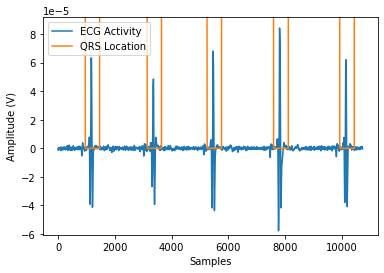

In [49]:
plt.plot(ECG_data[:window_size])
plt.plot(QRS_label[:window_size])
plt.ylim([np.min(ECG_data), np.max(ECG_data)])
plt.xlabel('Samples')
plt.ylabel('Amplitude (V)')
plt.legend(['ECG Activity', 'QRS Location'])
plt.show()

Function to obtain the synthetic dataset

In [50]:
def adjust_ecg_snr(curr_EMG, curr_ECG, desired_snr):
    # Calculate the power of the EMG signal
    signal_power = np.var(curr_EMG)

    # Calculate the required power of the noise (ECG) to achieve the desired SNR
    noise_power = signal_power / (10 ** (desired_snr / 10))

    # Adjust the ECG signal to match the required noise power
    curr_ECG_var = np.var(curr_ECG)
    if curr_ECG_var == 0:
        return curr_ECG  # Avoid division by zero
    scaling_factor = np.sqrt(noise_power / curr_ECG_var)
    return curr_ECG * scaling_factor

def get_dataset(dataset_size, window_size, EMG_data, ECG_data, QRS_label, desired_snr):
    x = []
    y = []
    labels = []
    
    count = 0    
    while count < dataset_size:
        i = np.random.randint(window_size, EMG_data.shape[0]) # random biceps EMG index
        if np.all(EMG_gradient[i-window_size:i]>1e-8): # ensure the EMG data is from a contraction
            while True:
                rng_ECG_int = np.random.randint(window_size, ECG_data.shape[0]) # random HR index
                if np.max(ECG_data[rng_ECG_int-window_size+200:rng_ECG_int-200]) > 4e-5: # ensure the R peak is a sufficient amplitude
                    curr_ECG = ECG_data[rng_ECG_int-window_size:rng_ECG_int] # obtain the hr data
                    curr_label = QRS_label[rng_ECG_int-window_size:rng_ECG_int] # obtain the label for the hr segment
                    break
        
            curr_ECG = curr_ECG - np.mean(curr_ECG) # DC offset on the hr data
            curr_ECG = np.expand_dims(curr_ECG, axis=1)

            curr_EMG = EMG_data[i-window_size:i] # Use the rng biceps EMG index to obtain a window of biceps EMG data
            curr_EMG = curr_EMG - np.mean(curr_EMG) # DC offset on the biceps EMG data
            curr_EMG = np.expand_dims(curr_EMG, axis=1)
            
            # Adjust the ECG signal to achieve the desired SNR
            scaled_ECG = adjust_ecg_snr(curr_EMG, curr_ECG, desired_snr)

            # Calculate curr_inputs and curr_outputs
            curr_inputs = curr_EMG + scaled_ECG
            curr_outputs = curr_EMG
            
            # Append to lists
            x.append(curr_inputs*1000)
            y.append(curr_outputs*1000)
            labels.append(curr_label)

            count += 1

    x = np.array(x)
    y = np.array(y)
    labels = np.array(labels)
    return x, y, labels

In [51]:
snr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_train = []
y_train = []
label_train = []

x_val = {}
y_val = {}
label_val = {}

for i in range(2):
    for desired_snr in snr_list:
        x, y, label = get_dataset(dataset_size=500, window_size=window_size, 
                                    EMG_data=EMG_data, ECG_data=ECG_data, 
                                    QRS_label=QRS_label, desired_snr=desired_snr)

        if i == 0:
            x_train.append(x)
            y_train.append(y)
            label_train.append(label)

            x_val[desired_snr] = x
            y_val[desired_snr] = y
            label_val[desired_snr] = label

x_train = np.vstack(x_train)
y_train = np.vstack(y_train)
label_train = np.vstack(label_train)

Signal-Noise calculation as described in "Abbaspour, S., Fallah, A., 2014. Removing ECG artifact from the surface EMG signal using adaptive subtraction technique. Journal of biomedical physics & engineering 4, 33."

In [52]:
def SNR(y_true, y_pred):
    diff = y_true - y_pred
    
    num = np.var(y_true)
    den = np.var(diff)

    # calculate the SNR in dB
    snr = 10*np.log10(num/den)
    return snr

In [53]:
for i, key in enumerate(x_val.keys()):
    print(key)

1
2
3
4
5
6
7
8
9
10


Calculate the mean ± standard deviation of the dataset's SNR 

In [54]:
snr_all = []
for i in range(x_train.shape[0]):
    snr_all.append(SNR(y_train[i],x_train[i]))

snr_all = np.array(snr_all)

print("Mean:", np.mean(snr_all))
print("STD:", np.std(snr_all))

Mean: 5.5
STD: 2.8722813232690143


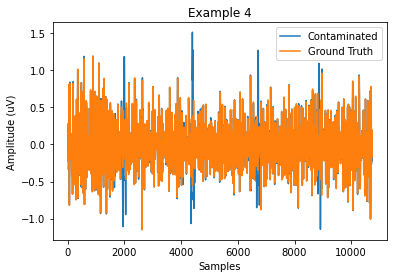

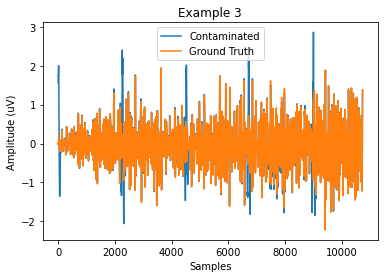

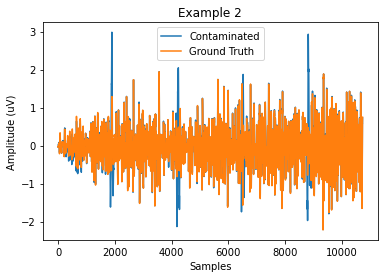

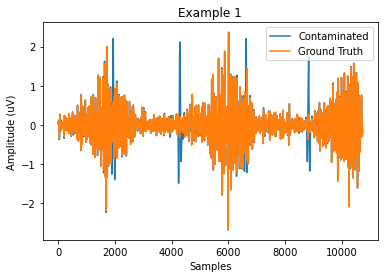

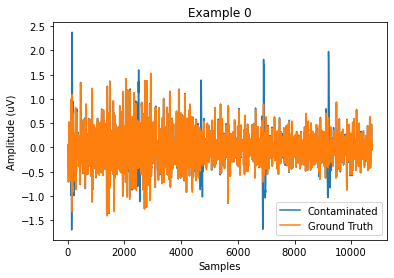

In [55]:
# Plot examples of contaminated and ground truth data
snr = 5
for i in reversed(range(5)):
    plt.plot(x_val[snr][i], label='Contaminated')
    plt.plot(y_val[snr][i], label='Ground Truth')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (uV)')
    plt.title('Example ' + str(i))
    # plt.ylim([np.min(x[i])-1, np.max(x[i]+1)])
    plt.show()

In [56]:
# Shuffle the dataset
x_train, y_train, label_train = shuffle(x_train, y_train, label_train)

print("Supervised Shape:", x_train.shape)

Supervised Shape: (5000, 10740, 1)


In [57]:
# with open('../../Data/Preprocessed Data/Synthetic/Validation/x_val.pkl', 'wb') as f:
#     pickle.dump(x_val, f)

# with open('../../Data/Preprocessed Data/Synthetic/Validation/y_val.pkl', 'wb') as f:
#     pickle.dump(y_val, f)

# with open('../../Data/Preprocessed Data/Synthetic/Validation/label_val.pkl', 'wb') as f:
#     pickle.dump(label_val, f)

In [58]:
def get_sequences(arr_size, data, ecg_label, window_size=window_size):
    
    x_count = 0
    x = []
    label = []
    while x_count < arr_size:
        i = np.random.randint(window_size, data.shape[0])
        if np.sum(ecg_label[i-window_size+200:i-200]==0) > 120:
            curr_data = data[i-window_size:i]
            x.append(curr_data)
            label.append(ecg_label[i-window_size:i])
            x_count += 1

    y_count = 0
    y = []
    while y_count < arr_size:
        i = np.random.randint(window_size, data.shape[0])
        if np.all(ecg_label[i-window_size:i]==1):
            curr_data = data[i-window_size:i]
            y.append(curr_data)
            y_count += 1

    x = np.array(x)
    y = np.array(y)
    label = np.array(label)
    
    return x, y, label

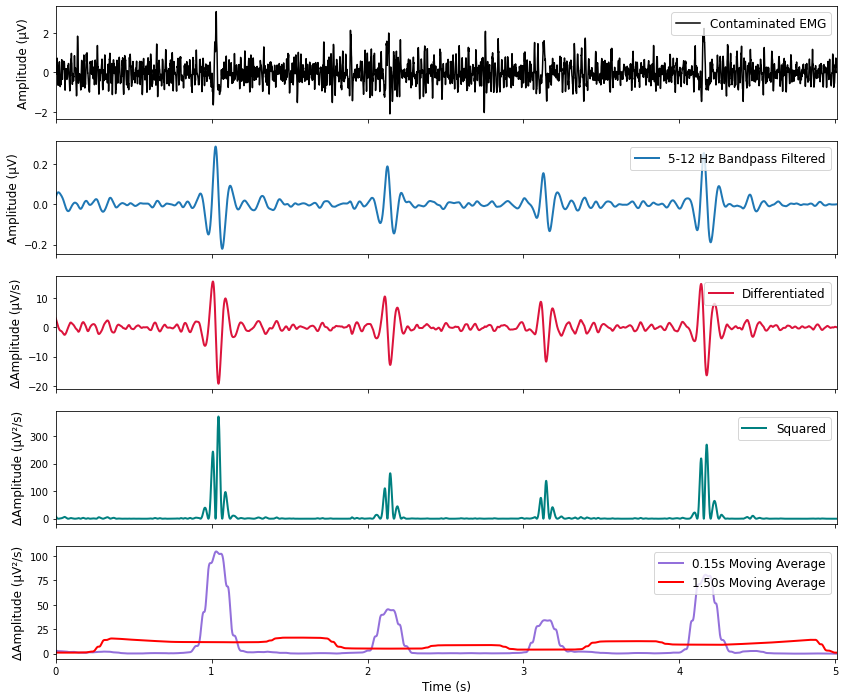

(15000, 1072, 1)

In [59]:
gan_x, gan_y, gan_label = [], [], []
for i in range(x_train.shape[0]):
    if i == 6:
        plotting = True
        saveplot = True
    else:
        plotting = False
        saveplot = False
        
    curr_ecg_label = getlabels(x_train[i], plotting=plotting, saveplot=saveplot)
    curr_x, curr_y, curr_label = get_sequences(arr_size=3, data=x_train[i], ecg_label=curr_ecg_label, window_size=1072)
    gan_x.append(curr_x)
    gan_y.append(curr_y)
    gan_label.append(curr_label)
gan_x = np.vstack(gan_x)
gan_y = np.vstack(gan_y)
gan_label = np.vstack(gan_label)

gan_y.shape

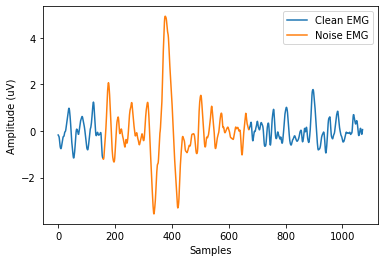

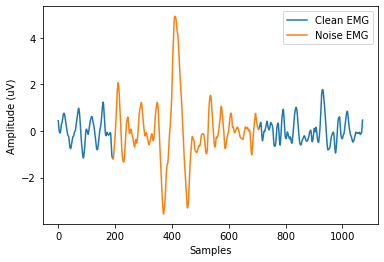

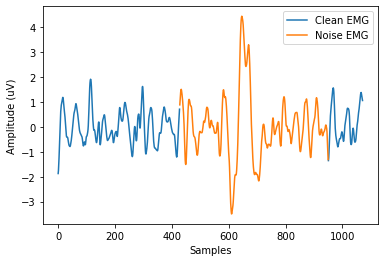

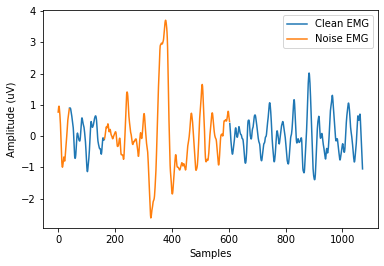

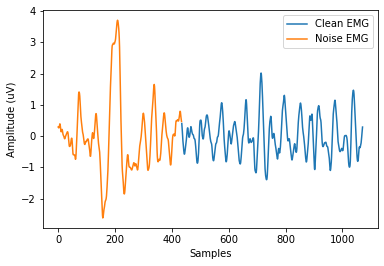

In [60]:
for i in range(5):
    tmp_x1 = gan_x[i].copy()
    tmp_x1[gan_label[i]==0] = np.nan
    tmp_x2 = gan_x[i].copy()
    tmp_x2[gan_label[i]==1] = np.nan

    plt.plot(tmp_x1, label='Clean EMG')
    plt.plot(tmp_x2, label='Noise EMG')
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (uV)")
    plt.legend()
    plt.show()


In [61]:
# np.save('../../Data/Preprocessed Data/Synthetic/Training/x_syn.npy', gan_x)
# np.save('../../Data/Preprocessed Data/Synthetic/Training/y_syn.npy', gan_y)
# np.save('../../Data/Preprocessed Data/Synthetic/Training/label_syn.npy', gan_label)